In [1]:
import os
import glob
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from llava.constants import IMAGE_TOKEN_INDEX
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, tokenizer_image_token

/home/chengzhang/anaconda3/envs/minigpt4/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-10-11 02:51:03,341] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
model_base = "/home/chengzhang/models/llava/llava-v1-0719-336px-lora-merge-vicuna-13b-v1.3"
model_path = "/home/chengzhang/models/llava/llava-336px-pretrain-vicuna-13b-v1.3"
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path, model_base, model_name
)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=True`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading LLaVA from base model...


Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 32000. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [3]:
linear_modules: dict[str, torch.nn.Linear] = {}

for i, layer in enumerate(model.model.layers):
    linear_modules[f'llama/{i}-q-proj'] = layer.self_attn.q_proj
    linear_modules[f'llama/{i}-k-proj'] = layer.self_attn.k_proj
    linear_modules[f'llama/{i}-v-proj'] = layer.self_attn.v_proj
    linear_modules[f'llama/{i}-o-proj'] = layer.self_attn.o_proj
    linear_modules[f'llama/{i}-gate-proj'] = layer.mlp.gate_proj
    linear_modules[f'llama/{i}-down-proj'] = layer.mlp.down_proj
    linear_modules[f'llama/{i}-up-proj'] = layer.mlp.up_proj

for name, module in linear_modules.items():
    module.unique_name = name

ln_modules: dict[str, torch.nn.Linear] = {}

for i, layer in enumerate(model.model.layers):
    ln_modules[f'llama/{i}-input-ln'] = layer.input_layernorm
    ln_modules[f'llama/{i}-post-attn-ln'] = layer.post_attention_layernorm

for name, module in ln_modules.items():
    module.unique_name = name

In [4]:
with open('/home/chengzhang/datasets/OK-VQA/question/OpenEnded_mscoco_val2014_questions.json') as f:
    questions = json.loads(f.read())['questions']

hooks = []

In [5]:
SNAPSHOT_PATH = '/home/chengzhang/Multimodal-Quantization/LLaVA/snapshot'

In [6]:
def save_activations(hooks):

    for i in range(100):

        q = questions[i]
        question = q['question']
        question_id = q['question_id']

        input_ids = torch.tensor(tokenizer(question)['input_ids']).unsqueeze(0).cuda()

        act_folder = f'{SNAPSHOT_PATH}/activations-text/{question_id}'
        os.makedirs(f'{act_folder}/vit', exist_ok=True)
        os.makedirs(f'{act_folder}/q-former', exist_ok=True)
        os.makedirs(f'{act_folder}/llama', exist_ok=True)

        for hook in hooks:
            hook.remove()
        hooks = []

        def hook(m, input, output):
            torch.save(input, f'{act_folder}/{m.unique_name}.pt')

        for name, module in linear_modules.items():
            hooks.append(module.register_forward_hook(hook))

        for name, module in ln_modules.items():
            hooks.append(module.register_forward_hook(hook))

        model(input_ids=input_ids)

# save_activations(hooks)

In [7]:
def load_act(
    path: str,
    comp: str,
    seq_start: int = 0,
    seq_end: int = 10,
    token_start: int = None,
    token_end: int = None
) -> np.ndarray:
    acts = []
    tokens = 0
    for i in range(seq_start, seq_end):
        question_id = questions[i]['question_id']
        act_folder = f'{path}/{question_id}'
        act: torch.Tensor = torch.load(f'{act_folder}/llama/{comp}.pt')[0][0]
        if token_end is not None:
            act = act[:token_end]
        if token_start is not None:
            act = act[token_start:]
        acts.append(act.abs().max(dim=0).values.detach())
        # acts.append(act.abs().sum(dim=0).detach())
        tokens += act.shape[0]
    return torch.stack(acts).max(dim=0).values.cpu().numpy()
    # return (torch.stack(acts).sum(dim=0) / tokens).cpu().numpy()

In [8]:
layer = 31
comp = 'q-proj'
mm_per_channel = load_act(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}')
text_per_channel = load_act(f'{SNAPSHOT_PATH}/activations-text', f'{layer}-{comp}')

In [9]:
def plot_layer(left: np.ndarray, right: np.ndarray, titles: list[str]):
    channels = left.shape[-1]
    outliers = channels // 100

    left_outliers = left.argsort()[-outliers:]
    right_outliers = right.argsort()[-outliers:]
    old_outliers = set(left_outliers) - set(right_outliers)
    new_outliers = set(right_outliers) - set(left_outliers)
    print(len(new_outliers))

    left_colors = np.tile(np.array([0x1f, 0x77, 0xb4]) / 255, (channels, 1))
    right_colors = np.tile(np.array([0x1f, 0x77, 0xb4]) / 255, (channels, 1))
    for idx in left_outliers:
        left_colors[idx] = np.array([0x2c, 0xa0, 0x2c]) / 255
    for idx in right_outliers:
        right_colors[idx] = np.array([0x2c, 0xa0, 0x2c]) / 255
    for idx in old_outliers:
        left_colors[idx] = np.array([0xff, 0x7f, 0x0e]) / 255
    for idx in new_outliers:
        right_colors[idx] = np.array([0xd6, 0x27, 0x28]) / 255
    
    max_val = max(left.max(), right.max())

    print(left.argmax(), left.max())
    print(right.argmax(), right.max())

    groups = (channels + 512 - 1) // 512

    plt.figure(figsize=(15, 2 * groups))

    def plot_group(tensor, colors, start, stop, idx, title=None):
        ax = plt.subplot(groups, 2, idx)
        ax.bar(np.arange(start, stop), tensor[start:stop], width=np.ones(stop - start), color=colors[start:stop])
        # ax.set_ylim(0, np.ceil(max_val))
        ax.set_ylim(0, max_val)
        ax.set_xlim(start, start + 512)
        ax.set_xticks(np.arange(start, start + 513, 64))
        if title is not None:
            ax.set_title(title)

    for group_id in range(groups):
        start = group_id * 512
        stop = min(start + 512, channels)
        plot_group(left, left_colors, start, stop, group_id * 2 + 1, titles[1] if group_id == 0 else None)
        plot_group(right, right_colors, start, stop, group_id * 2 + 2, titles[2] if group_id == 0 else None)

    plt.suptitle(titles[0])

27
3275 8.97
2230 11.2


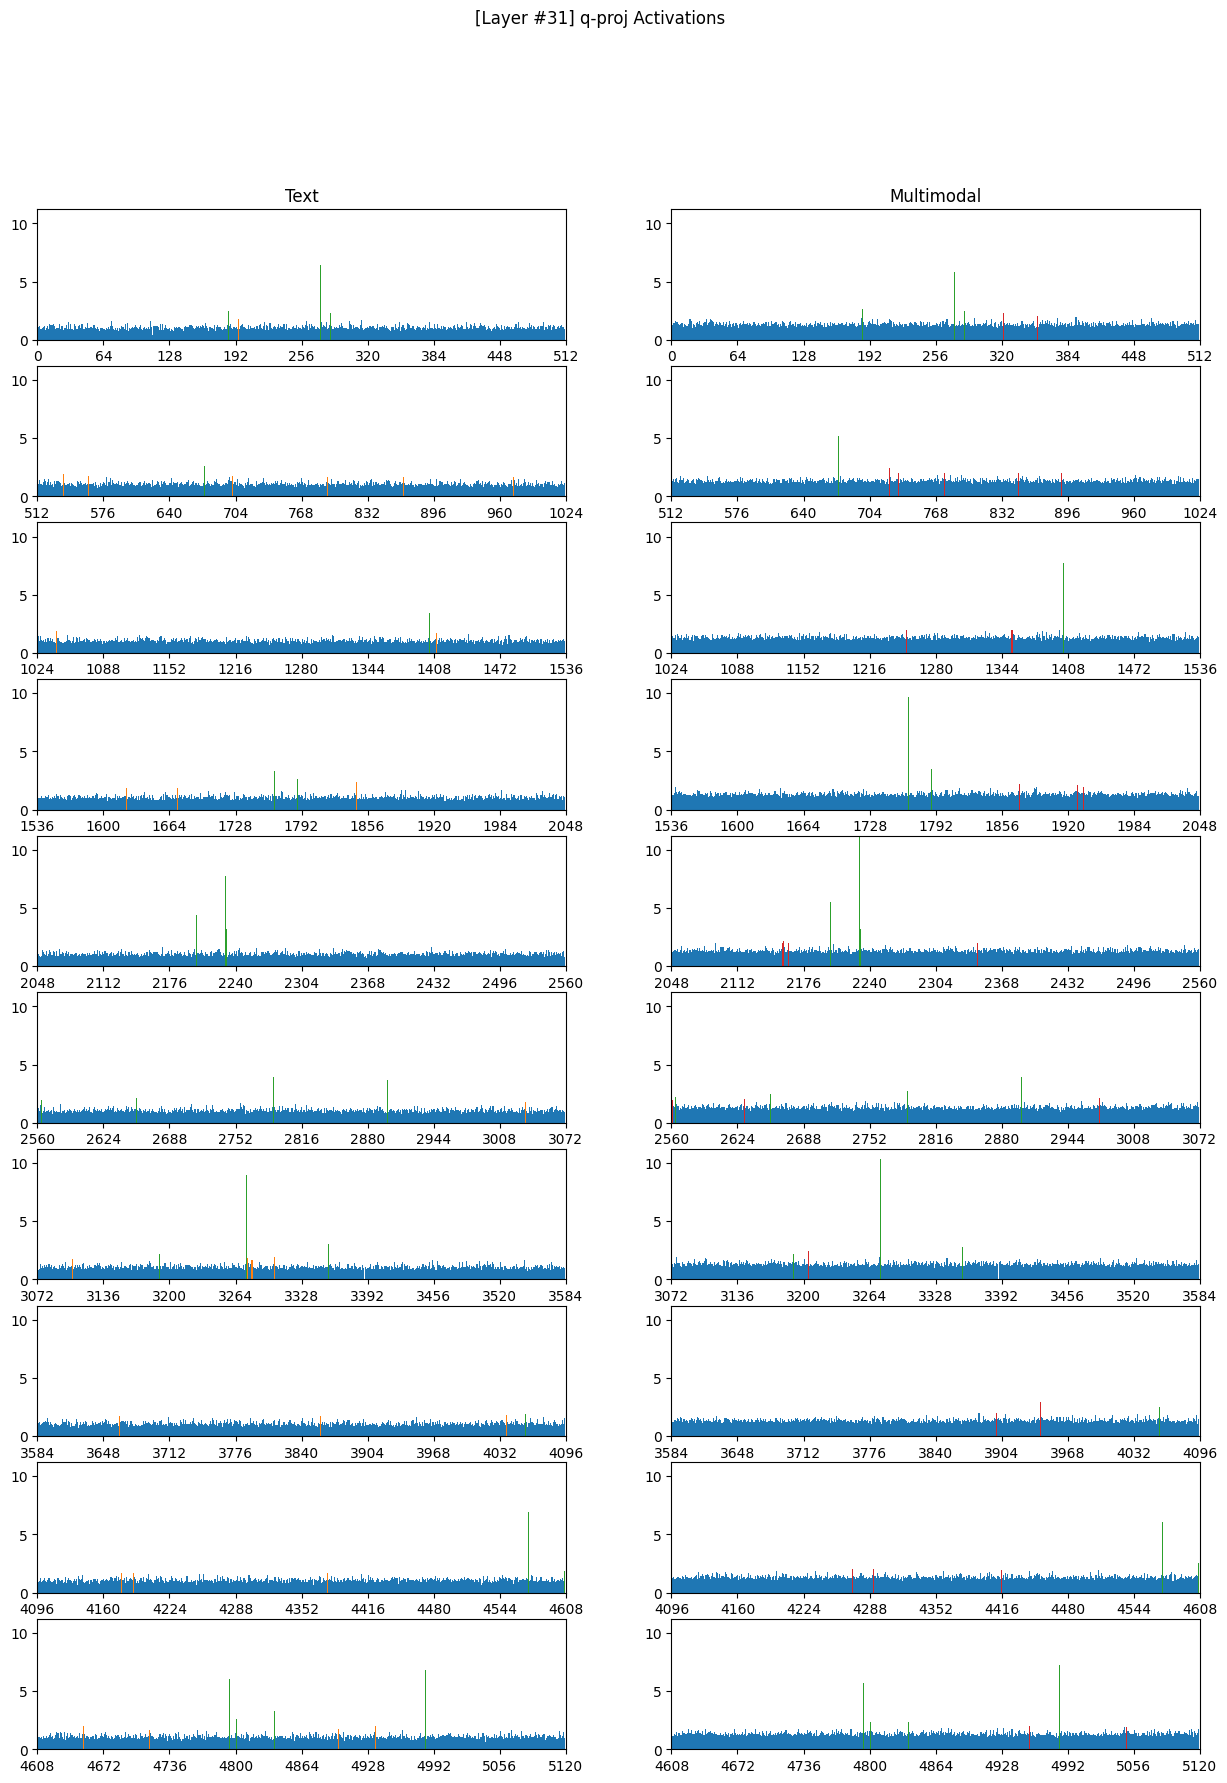

In [10]:
layer = 31
comp = 'q-proj'
mm_per_channel = load_act(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}')
text_per_channel = load_act(f'{SNAPSHOT_PATH}/activations-text', f'{layer}-{comp}')
titles = [
    f'[Layer #{layer}] {comp} Activations',
    'Text',
    'Multimodal',
]
plot_layer(text_per_channel, mm_per_channel, titles)

16
2230 13.83
2230 15.66


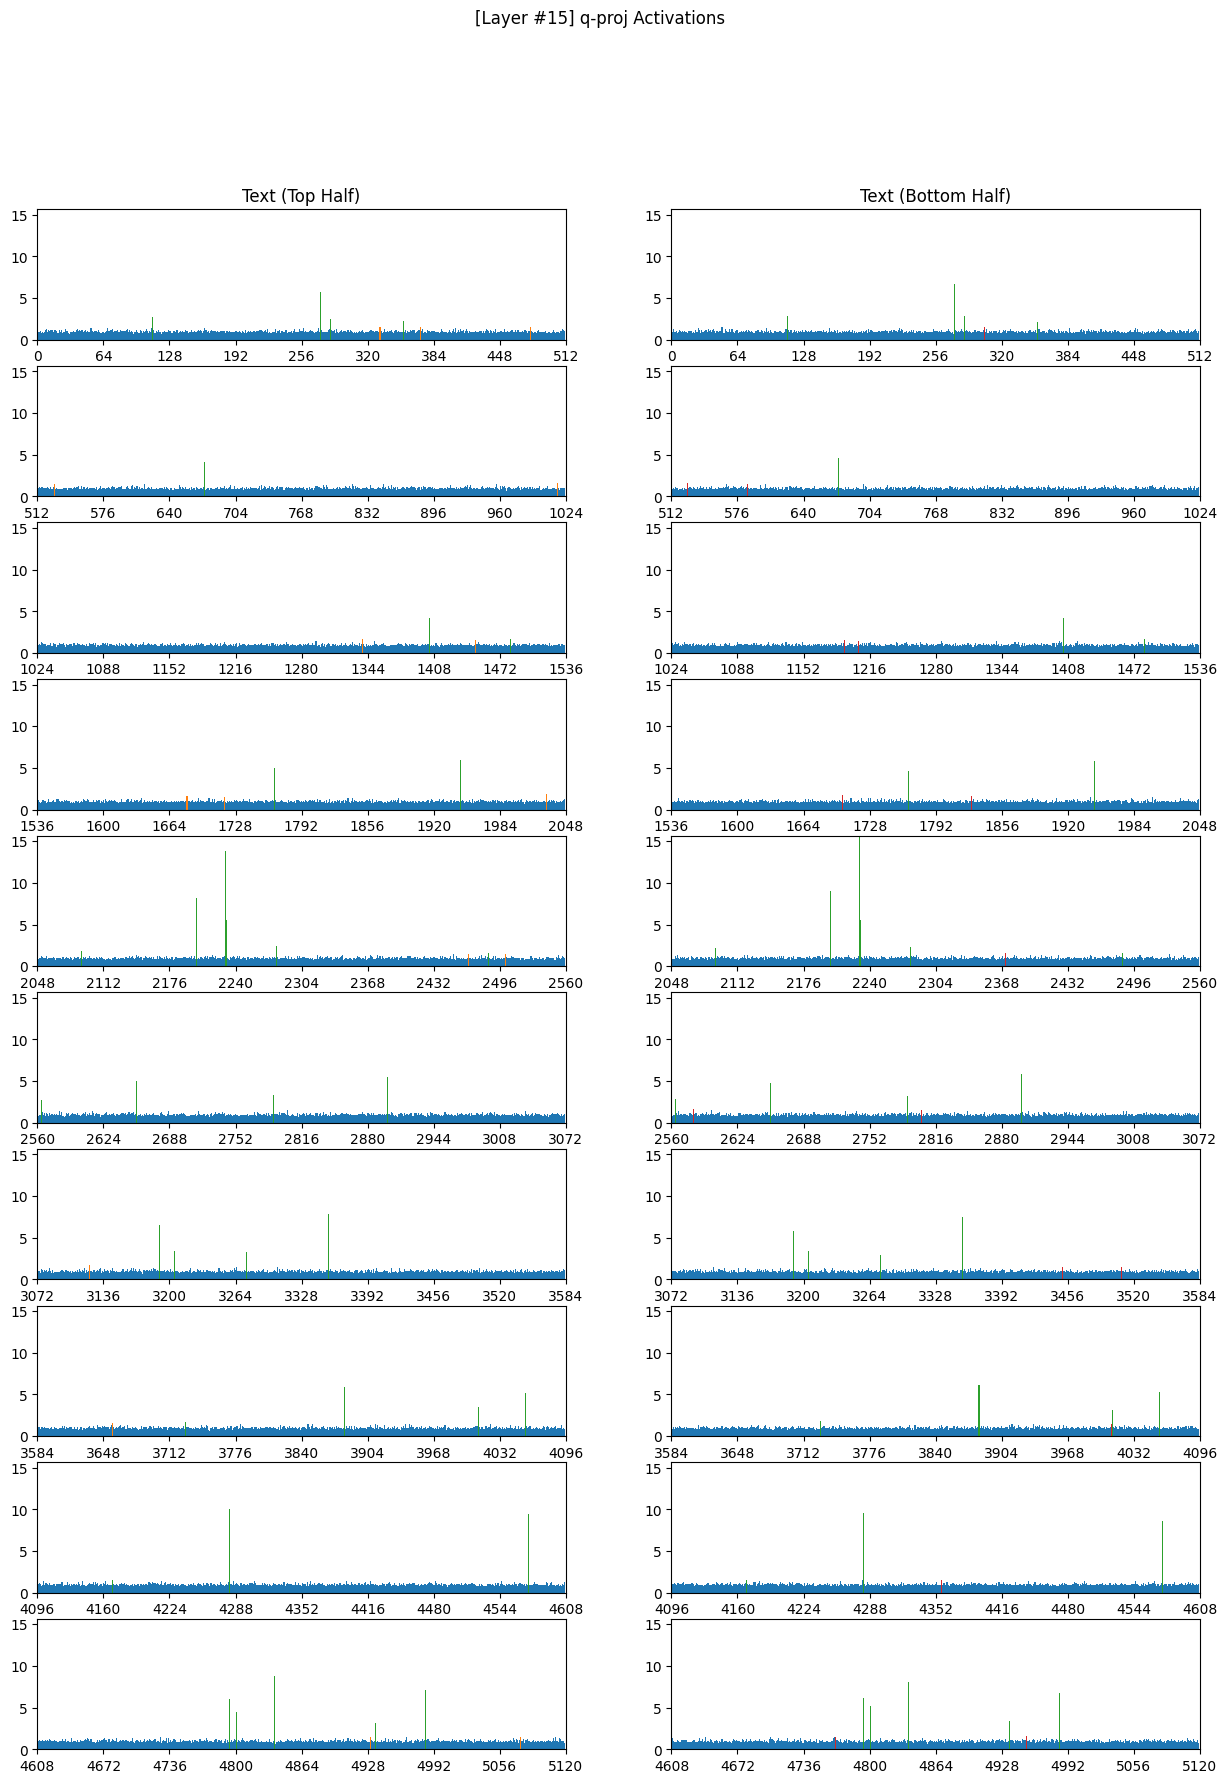

In [11]:
layer = 15
comp = 'q-proj'
text_per_channel_1 = load_act(f'{SNAPSHOT_PATH}/activations-text', f'{layer}-{comp}', seq_start=0, seq_end=50)
text_per_channel_2 = load_act(f'{SNAPSHOT_PATH}/activations-text', f'{layer}-{comp}', seq_start=50, seq_end=100)
titles = [
    f'[Layer #{layer}] {comp} Activations',
    'Text (Top Half)',
    'Text (Bottom Half)',
]
plot_layer(text_per_channel_1, text_per_channel_2, titles)

16
2230 11.51
2230 10.766


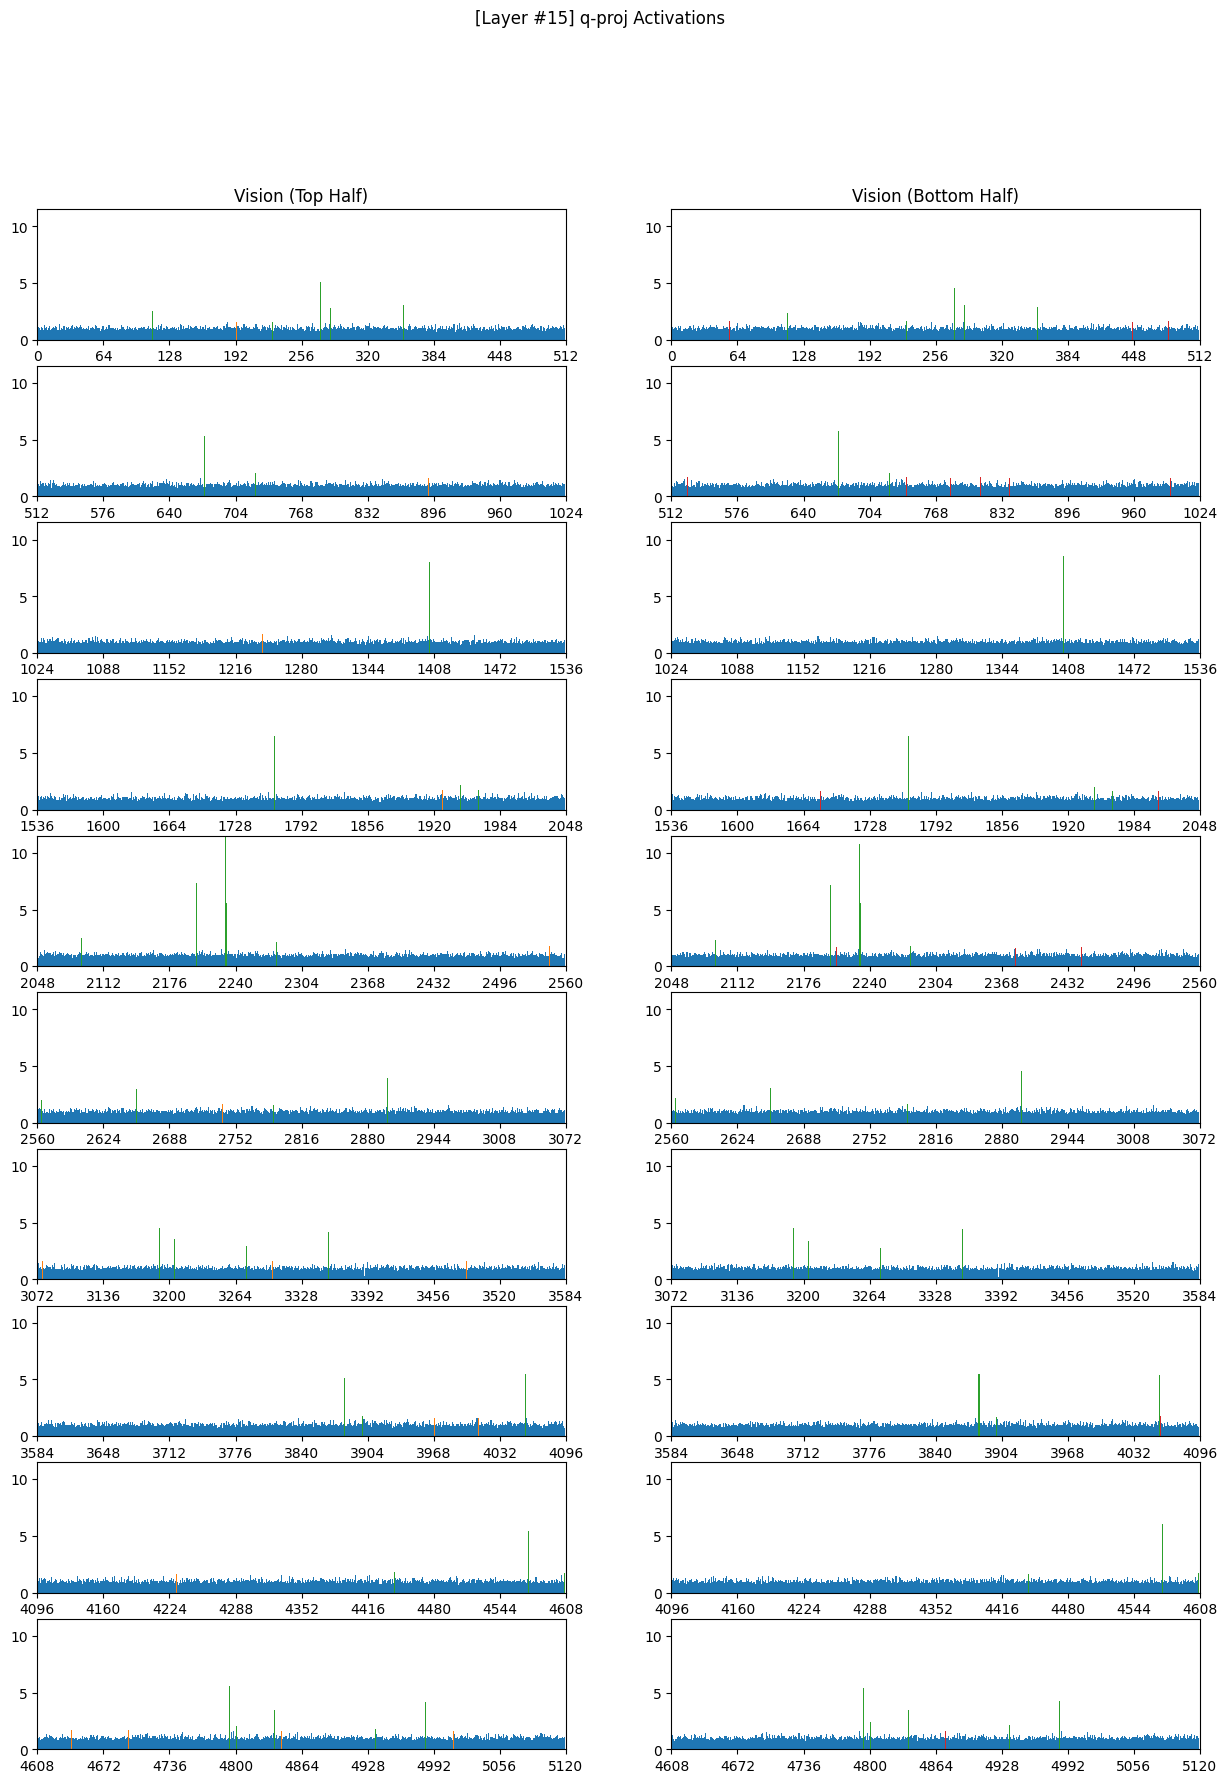

In [12]:
layer = 15
comp = 'q-proj'
mm_per_channel_1 = load_act(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}', seq_start=0, seq_end=5, token_end=577)
mm_per_channel_2 = load_act(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}', seq_start=5, seq_end=10, token_end=577)
titles = [
    f'[Layer #{layer}] {comp} Activations',
    'Vision (Top Half)',
    'Vision (Bottom Half)',
]
plot_layer(mm_per_channel_1, mm_per_channel_2, titles)

37
2231 6.652
2231 6.652


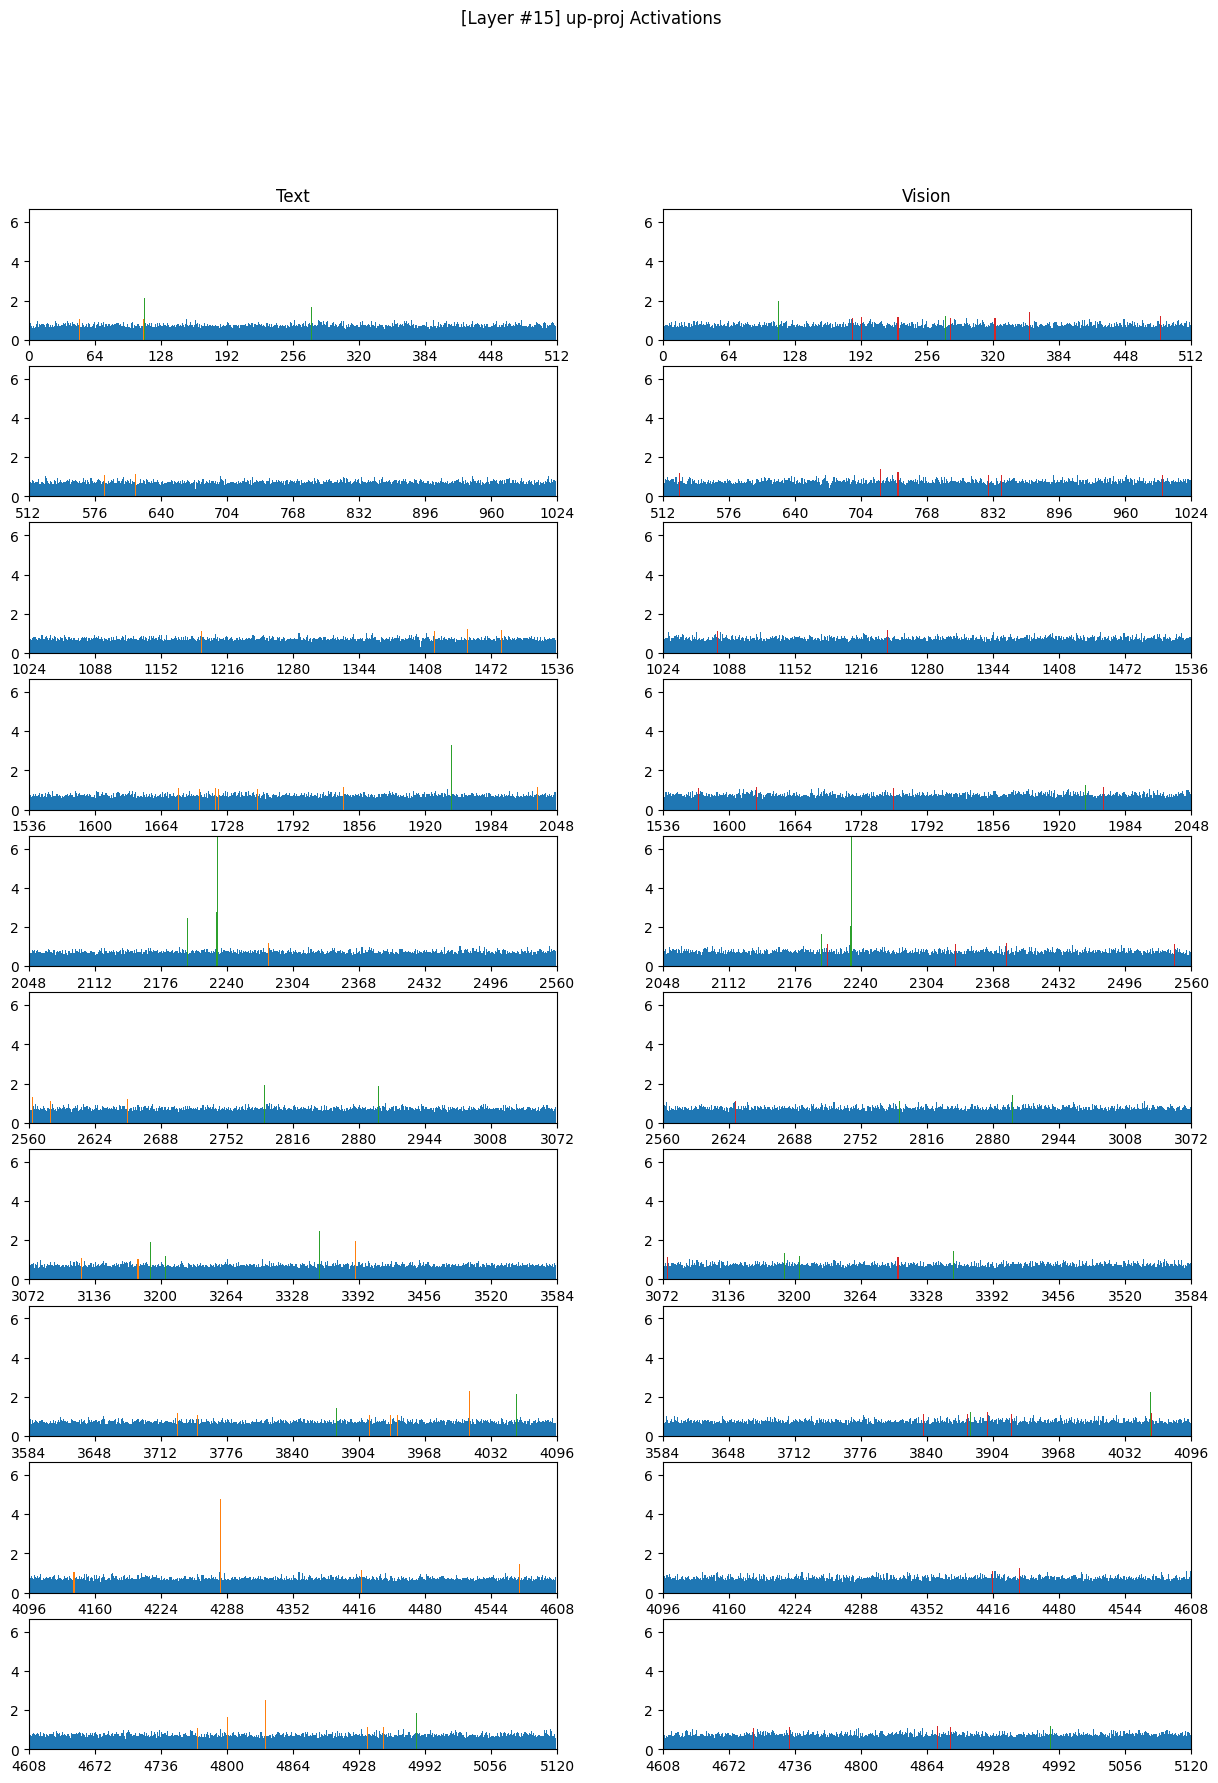

In [16]:
layer = 15
comp = 'up-proj'
vision_per_channel = load_act(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}', token_end=577)
# text_per_channel = load_act(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}', token_start=577)
text_per_channel = load_act(f'{SNAPSHOT_PATH}/activations-text', f'{layer}-{comp}', seq_start=0, seq_end=100)
titles = [
    f'[Layer #{layer}] {comp} Activations',
    'Text',
    'Vision',
]
plot_layer(text_per_channel, vision_per_channel, titles)